## Bordes

#### Detección de bordes

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

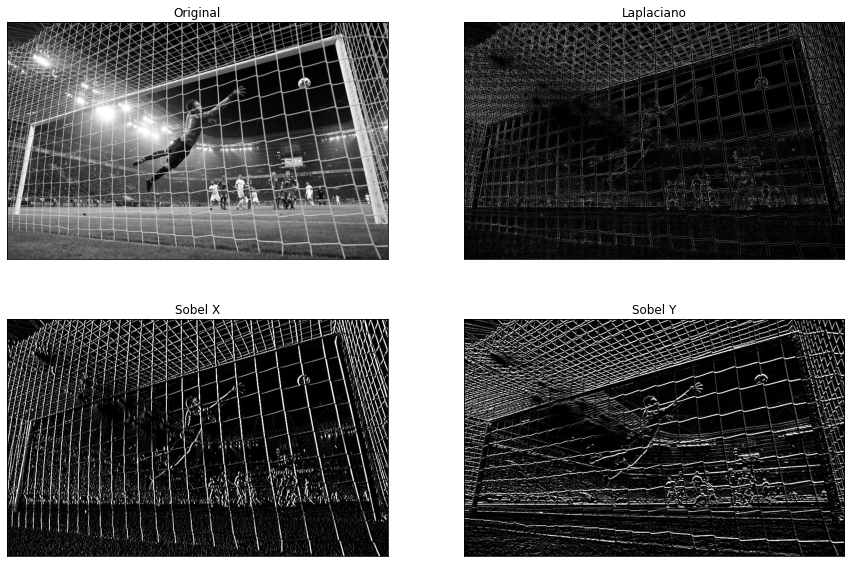

In [3]:
img = cv.imread('golazo.jpg',0)

#grises=True
grises=False
if grises:
    # En escala de grises
    laplacian = cv.Laplacian(img, cv.CV_64F)
    sobelx = cv.Sobel(img, cv.CV_64F, 1, 0, ksize=3)
    sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=3)
else:
    # En blanco y negro
    laplacian = cv.Laplacian(img,cv.CV_8U)
    sobelx = cv.Sobel(img,cv.CV_8U,1,0,ksize=3)
    sobely = cv.Sobel(img,cv.CV_8U,0,1,ksize=3)

plt.figure(figsize=(15,10))
ax1=plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
ax2=plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplaciano'), plt.xticks([]), plt.yticks([])
ax3=plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
ax4=plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

#### Detector de Canny (a mano)

Blur 0.000997304916381836 segundos
Gradientes 0.05602765083312988 segundos
No-máximos 8.945589780807495 segundos
Histéresis 0.012996673583984375 segundos
Armado imagen bordes 1.6249289512634277 segundos


(-0.5, 1199.5, 755.5, -0.5)

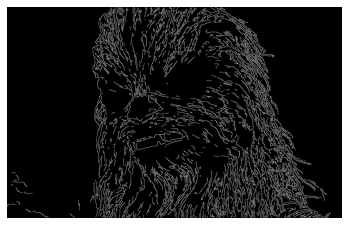

In [4]:
img = cv.imread('chewbacca.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Suavizado Gaussiano
#====================
start = time.time()

blur = cv.GaussianBlur(gray,(5,5),0)

elapsed = time.time()-start
print('Blur {} segundos'.format(elapsed))

# Gradientes
#===========
start = time.time()

# Aplicamos Sobelx en 'float32' y luego convertimos de nuevo a 8-bit para evitar overflow
sobelx_64 = cv.Sobel(blur,cv.CV_32F,1,0,ksize=3)
absx_64 = np.absolute(sobelx_64)
sobelx_8u1 = absx_64/absx_64.max()*255
sobelx_8u = np.uint8(sobelx_8u1)

# De igual modo para Sobely
sobely_64 = cv.Sobel(blur,cv.CV_32F,0,1,ksize=3)
absy_64 = np.absolute(sobely_64)
sobely_8u1 = absy_64/absy_64.max()*255
sobely_8u = np.uint8(sobely_8u1)

# De los gradiente calculamos Magnitud y lo pasamos a 8-bit (Opcional)
mag = np.hypot(sobelx_8u, sobely_8u)
mag = mag/mag.max()*255
mag = np.uint8(mag)

# Encontramos la Dirección y la pasamos a grados
theta = np.arctan2(sobely_64, sobelx_64)
angle = np.rad2deg(theta)

elapsed = time.time()-start
print('Gradientes {} segundos'.format(elapsed))

# Supresión de no-máximos
#========================
start = time.time()

# Encontramos los píxels vecinos (b,c) en la dirección (redondeadea) del gradiente y aplicamos la supresión de no-máximos
M, N = mag.shape
Non_max = np.zeros((M,N), dtype= np.uint8)

for i in range(1,M-1):
    for j in range(1,N-1):
       # Horizontal 0
        if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
            b = mag[i, j+1]
            c = mag[i, j-1]
        # Diagonal 45
        elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
            b = mag[i+1, j+1]
            c = mag[i-1, j-1]
        # Vertical 90
        elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
            b = mag[i+1, j]
            c = mag[i-1, j]
        # Diagonal 135
        elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
            b = mag[i+1, j-1]
            c = mag[i-1, j+1]           
            
        # Supresión de no-máximos
        if (mag[i,j] >= b) and (mag[i,j] >= c):
            Non_max[i,j] = mag[i,j]
        else:
            Non_max[i,j] = 0

elapsed = time.time()-start
print('No-máximos {} segundos'.format(elapsed))

# Umbralizado por histéresis
#===========================
start = time.time()

UmbralAlto = 50
UmbralBajo = 15

M, N = Non_max.shape
out = np.zeros((M,N), dtype= np.uint8)

# Si la intensidad de un borde es mayor a 'UmbralAlto' es seguro un umbral, debajo de 'UmbralBajo' seguro no es
strong_i, strong_j = np.where(Non_max >= UmbralAlto)
zeros_i, zeros_j = np.where(Non_max < UmbralBajo)

# Bordes débiles
weak_i, weak_j = np.where((Non_max <= UmbralAlto) & (Non_max >= UmbralBajo))

# Setear el mismo valor a todos los tipos de píxel
out[strong_i, strong_j] = 255
out[zeros_i, zeros_j ] = 0
out[weak_i, weak_j] = 75

elapsed = time.time()-start
print('Histéresis {} segundos'.format(elapsed))

# Armo la imagen de bordes
#=========================
start = time.time()
M, N = out.shape
for i in range(1, M-1):
    for j in range(1, N-1):
        if (out[i,j] == 75):
            if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                out[i, j] = 255
            else:
                out[i, j] = 0

elapsed = time.time()-start
print('Armado imagen bordes {} segundos'.format(elapsed))

# Muestro la imagen
#==================
plt.imshow(out, cmap='gray')
plt.axis('off')
#cv.imshow("Canny",out)

#### Detector de Canny con OpenCV

Tiempo de procesamiento 0.004998922348022461 segundos


(-0.5, 1199.5, 755.5, -0.5)

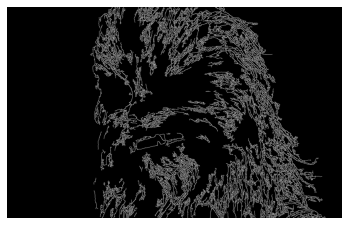

In [6]:
# Cargo la imagen
#================
img = cv.imread('chewbacca.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Aplico Canny
#=============
start = time.time()
edges = cv.Canny(img, threshold1=5, threshold2=200)
elapsed = time.time()-start
print('Tiempo de procesamiento {} segundos'.format(elapsed))

# Muestro la imagen
#==================
#cv.imshow("CannyCV",edges)
plt.imshow(edges, cmap='gray')
plt.axis('off')

(-0.5, 869.5, 541.5, -0.5)

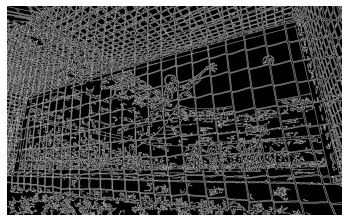

In [7]:
img = cv.imread('golazo.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img, threshold1=5, threshold2=200)

plt.imshow(edges, cmap='gray')
plt.axis('off')

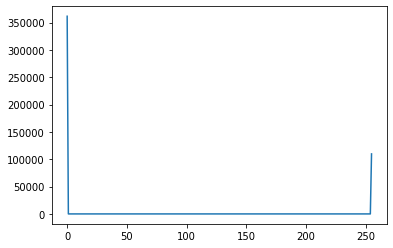

In [8]:
hist = cv.calcHist([edges],[0],None,[256],[0,256])
plt.figure()
plt.plot(hist)
plt.show()